In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import time
import os
import h5py
%matplotlib inline 
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
from visualization.visualize_funcs import *
sys.path.append('src_cython')
from zwatershed import *
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'

# Test Evaluation

In [2]:
threshes = [2000] # for i in range(1,6)]+[i*20000 for i in range(2,16)] # 100...1,000...100,000
iters = [10000]
strs = ["2"]
hdf5_gt_file = path_to_data + 'groundtruth_seg_thick.h5' #/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
hdf5_pred_file = path_to_data + 'tstvol-1_2.h5' # /tier2/turaga/singhc/train/output_200000/tstvol-1_2.h5'
out = path_to_data + 'out/'# '/groups/turaga/home/singhc/evaluation/out/'
save_threshes = threshes
rand = 0

hdf5_gt = h5py.File(hdf5_gt_file, 'r')
hdf5_aff = h5py.File(hdf5_pred_file, 'r')
gt = np.asarray(hdf5_gt[hdf5_gt.keys()[0]],dtype='uint32')
aff = np.asarray(hdf5_aff[hdf5_aff.keys()[0]],dtype='float32')

dims = np.array(aff.shape,dtype='uint32')
print 'dims:',aff.shape

# trim gt data - only works for perfect cubes
gt_data_dimension = gt.shape[0]
data_dimension = aff.shape[1]
if gt_data_dimension != data_dimension:
    print("data dimension do not match - clipping GT borders.")
    padding = (gt_data_dimension - data_dimension) / 2
    gt = gt[padding:(-1*padding),padding:(-1*padding),padding:(-1*padding)]
    print"New GT data shape :",gt.shape

segs,rand = zwatershed_and_metrics(gt, aff, threshes, save_threshes)
# segs = zwatershed(aff, threshes)
# rand = zwatershed_and_metrics_h5(gt, aff, threshes, save_threshes, out)
# zwatershed_h5(aff, threshes, out)

print rand
print sum(segs[0][0][0:100][0])

dims: (3, 432, 432, 432)
data dimension do not match - clipping GT borders.
New GT data shape : (432, 432, 432)
{'V_Rand_merge': [0.9873005281338733], 'V_Rand_split': [0.616834980447539], 'V_Rand': 0.7592893477008834}
13395142


# View Segmentations 

In [3]:
## Open training data and labels
data_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/data/'# 'nobackup/turaga/data/FlyEM/fibsem_medulla_7col/tstvol-520-1/'
os.chdir('/.')
f = h5py.File(data_folder + 'im_uint8.h5', 'r')
im = f[f.keys()[0]] # was 'main'
g = h5py.File(data_folder + 'groundtruth_aff.h5', 'r')
label_set = np.asarray(g[g.keys()[0]],dtype='float32') #3,z,y,x - was 'main'
label_set = np.transpose(label_set,(1,2,3,0))

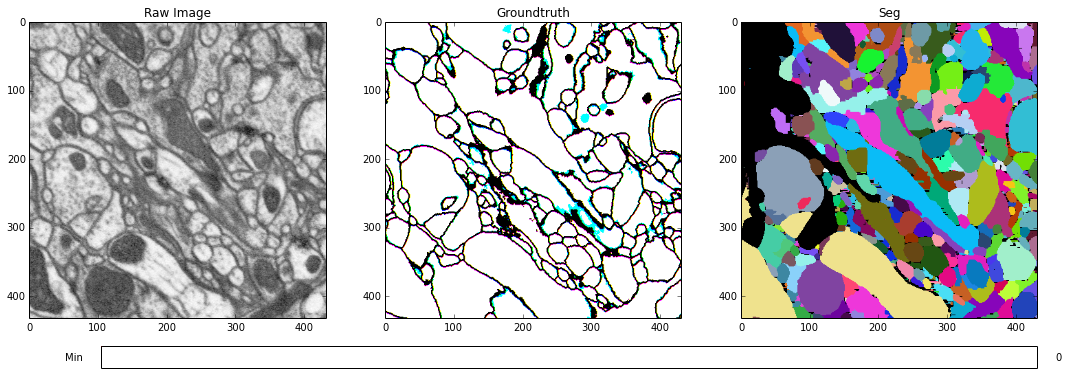

In [4]:
# view segs
seg = segs[0]
im,label_set=trim(im,label_set,seg)
display_seg(im, label_set, seg, im_size=label_set.shape[0], im2_size=seg.shape[0])

# Test Evaluate

In [2]:
threshes = [2000] #[0,100,400,800,1000,2000] # for i in range(1,6)]+[i*20000 for i in range(2,16)] # 100...1,000...100,000
iters = [10000]
strs = ["2"]
hdf5_gt_file = path_to_data + 'groundtruth_seg_thick.h5' #/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
hdf5_pred_file = path_to_data + 'tstvol-1_2.h5' # /tier2/turaga/singhc/train/output_200000/tstvol-1_2.h5'
out = path_to_data + 'out/'# '/groups/turaga/home/singhc/evaluation/out/'
save_threshes = threshes
rand = 0
p_small = 200
hdf5_gt = h5py.File(hdf5_gt_file, 'r')
hdf5_aff = h5py.File(hdf5_pred_file, 'r')
gt = np.asarray(hdf5_gt[hdf5_gt.keys()[0]],dtype='uint32')
aff = np.asarray(hdf5_aff[hdf5_aff.keys()[0]],dtype='float32')
aff = aff[:,p_small:(-1*p_small),p_small:(-1*p_small),p_small:(-1*p_small)]

dims = np.array(aff.shape,dtype='uint32')
print 'dims:',aff.shape

# trim gt data - only works for perfect cubes
gt_data_dimension = gt.shape[0]
data_dimension = aff.shape[1]
if gt_data_dimension != data_dimension:
    print("data dimension do not match - clipping GT borders.")
    padding = (gt_data_dimension - data_dimension) / 2
    gt = gt[padding:(-1*padding),padding:(-1*padding),padding:(-1*padding)]
    print"New GT data shape :",gt.shape

# segs,rand = zwatershed_and_metrics(gt, aff, threshes, save_threshes)
# segs = zwatershed(aff, threshes)
# rand = zwatershed_and_metrics_h5(gt, aff, threshes, save_threshes, out)
# zwatershed_h5(aff, threshes, out)
val = calc_rgn_graph(gt,aff)
print val

dims: (3, 32, 32, 32)
data dimension do not match - clipping GT borders.
New GT data shape : (32, 32, 32)
[335.0, 335.0, 1.0, 311.0, 311.0, 1.0, 304.0, 304.0, 1.0, 303.0, 303.0, 1.0, 250.0, 250.0, 1.0, 245.0, 245.0, 1.0, 232.0, 232.0, 1.0, 193.0, 193.0, 1.0, 188.0, 188.0, 1.0, 147.0, 147.0, 1.0, 139.0, 139.0, 1.0, 130.0, 130.0, 1.0, 99.0, 99.0, 1.0, 63.0, 63.0, 1.0, 57.0, 57.0, 1.0, 46.0, 46.0, 1.0, 17.0, 17.0, 1.0, 14.0, 14.0, 1.0, 277.0, 277.0, 0.9999998807907104, 240.0, 240.0, 0.9999998807907104, 183.0, 183.0, 0.9999998807907104, 135.0, 135.0, 0.9999998807907104, 7.0, 7.0, 0.9999998807907104, 6.0, 6.0, 0.9999998807907104, 299.0, 299.0, 0.9999997615814209, 5.0, 5.0, 0.9999997615814209, 4.0, 4.0, 0.9999997615814209, 357.0, 357.0, 0.9999996423721313, 356.0, 356.0, 0.9999996423721313, 297.0, 297.0, 0.9999996423721313, 289.0, 289.0, 0.9999996423721313, 220.0, 220.0, 0.9999996423721313, 204.0, 204.0, 0.9999996423721313, 106.0, 106.0, 0.9999996423721313, 358.0, 358.0, 0.9999995231628418, 3

In [3]:
val = np.array(val)
print len(val)
print 32*32
dim = len(val)/3
rgn_graph = val.reshape(dim,3)
rgn_flat= rgn_graph.flatten()
print rgn_graph[0:20]
x = sum(rgn_flat==0)

4287


NameError: name 'segs' is not defined